In [1]:
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(nlme))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(mgcv))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
setwd("/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/matched_cleaned_data")

env_data_file = "env_metadata.txt"
adiv_data_file = "alpha_diversity.txt"
habitat_file = "all_mdata_with_habitat.txt"

habitat_srs <- read.delim(habitat_file, row.names=1)

known.dtypes <- c('character', 'factor', "factor", "factor", "factor", 
                  "factor", 'numeric', 'numeric', 'numeric', 'numeric', 
                  'numeric', 'numeric', 'numeric', 'numeric', 'numeric',
                  'numeric', 'numeric', 'numeric', 'numeric', 'numeric')
active_set = c('CollectionAgency', 'Year', 'Month', 'StationName', 'Discharge_Susquehanna_14', 
               'day_length', 'Latitude', 'Depth', 'WTEMP', 'SALINITY')

envdata <- read.delim(env_data_file, row.names=1, colClasses=known.dtypes)[,active_set]
envdata <- cbind.data.frame(envdata, habitat_srs[rownames(envdata), c('anti_day_length', 'AC_PrinComp2',
                                                           'habitat', 'Month_Year', 'depth_float', 
                                                           'Longitude', 'julian_day', 'TrimCount',
                                                           'RawCount', 'DO', 'PH', 'Depth_Percentage')])
envdata[,'habitat'] <- factor(envdata[,'habitat'])
print(str(envdata))

'data.frame':	290 obs. of  22 variables:
 $ CollectionAgency        : Factor w/ 3 levels "DNR","ODU","Preheim": 3 3 3 3 3 3 3 3 3 3 ...
 $ Year                    : Factor w/ 3 levels "15","16","17": 1 1 1 1 1 1 1 1 1 1 ...
 $ Month                   : Factor w/ 6 levels "4","5","6","7",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ StationName             : Factor w/ 20 levels "CB22","CB31",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Discharge_Susquehanna_14: num  643639 643639 643639 643639 643639 ...
 $ day_length              : num  0.857 0.857 0.857 0.857 0.857 ...
 $ Latitude                : num  39 39 39 39 39 ...
 $ Depth                   : num  0.279 2.127 3.073 3.959 6.069 ...
 $ WTEMP                   : num  26.8 27.1 27.1 26.9 25.9 ...
 $ SALINITY                : num  4.86 5.96 6.72 6.67 10.1 ...
 $ anti_day_length         : num  0.516 0.516 0.516 0.516 0.516 ...
 $ AC_PrinComp2            : num  2.48 2.5 2.5 2.5 1.58 ...
 $ habitat                 : Factor w/ 3 levels "1","2","3": 3 3 3 3 1 2 2 2 

In [3]:
envdata[,'StatName'] <- NA
statg1 = c('CB22', 'CB31', 'CB32')
statg2 = c('CB33C', 'CB41C')
statg3 = c('CB42C', 'CB43C', 'CB44', 'CB51')
statg4 = c('CB52', 'CB53', 'CB54', 'CB71')
statg5 = c('CB61', 'CB62', 'CB63', 'CB64')
statg6 = c('CB72', 'CB73', 'CB74')

envdata[which(envdata[,'StationName'] %in% statg1),'StatName'] <- '1'
envdata[which(envdata[,'StationName'] %in% statg2),'StatName'] <- '2'
envdata[which(envdata[,'StationName'] %in% statg3),'StatName'] <- '3'
envdata[which(envdata[,'StationName'] %in% statg4),'StatName'] <- '4'
envdata[which(envdata[,'StationName'] %in% statg5),'StatName'] <- '5'
envdata[which(envdata[,'StationName'] %in% statg6),'StatName'] <- '6'

envdata$StatName <- factor(envdata$StatName)
print(sum(is.na(envdata[,'StatName'])))
table(envdata$StatName)

envdata[,'SalZone'] <- NA
oligohaline <- c('CB22', 'CB31')
mesohaline <- c('CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54')
polyhaline <- c('CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74')
envdata[which(envdata[,'StationName'] %in% oligohaline),'SalZone'] <- '1_oligohaline'
envdata[which(envdata[,'StationName'] %in% mesohaline),'SalZone'] <- '2_mesohaline'
envdata[which(envdata[,'StationName'] %in% polyhaline),'SalZone'] <- '3_polyhaline'
envdata$SalZone <- factor(envdata$SalZone)
print(sum(is.na(envdata[,'SalZone'])))
table(envdata$SalZone)

our_station = envdata[,'StationName'] == 'CB33C' 
envdata[,'depth_segment'] <- NA
envdata[which((!our_station) & envdata$depth_float > 2), 'depth_segment'] = 'Bottom'
envdata[which(envdata$depth_float < 2), 'depth_segment'] = 'Top'
envdata[which(our_station & envdata$depth_float > 11), 'depth_segment'] = 'Bottom'
envdata[is.na(envdata[,'depth_segment']),'depth_segment'] = 'Mid'
envdata[,'depth_segment'] = factor(envdata[,'depth_segment'], levels=c('Top', 'Mid', 'Bottom'))
table(envdata$depth_segment)

[1] 0



  1   2   3   4   5   6 
 25 103  43  47  45  27 

[1] 0



1_oligohaline  2_mesohaline  3_polyhaline 
           18           185            87 


   Top    Mid Bottom 
    67     46    177 

In [4]:
adiv_df <- read.delim(adiv_data_file, row.names=1)[rownames(envdata),]
fulldata = cbind(envdata, adiv_df)
fulldata[,'observed_otus'] <- NULL
print(str(fulldata))

'data.frame':	290 obs. of  27 variables:
 $ CollectionAgency        : Factor w/ 3 levels "DNR","ODU","Preheim": 3 3 3 3 3 3 3 3 3 3 ...
 $ Year                    : Factor w/ 3 levels "15","16","17": 1 1 1 1 1 1 1 1 1 1 ...
 $ Month                   : Factor w/ 6 levels "4","5","6","7",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ StationName             : Factor w/ 20 levels "CB22","CB31",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Discharge_Susquehanna_14: num  643639 643639 643639 643639 643639 ...
 $ day_length              : num  0.857 0.857 0.857 0.857 0.857 ...
 $ Latitude                : num  39 39 39 39 39 ...
 $ Depth                   : num  0.279 2.127 3.073 3.959 6.069 ...
 $ WTEMP                   : num  26.8 27.1 27.1 26.9 25.9 ...
 $ SALINITY                : num  4.86 5.96 6.72 6.67 10.1 ...
 $ anti_day_length         : num  0.516 0.516 0.516 0.516 0.516 ...
 $ AC_PrinComp2            : num  2.48 2.5 2.5 2.5 1.58 ...
 $ habitat                 : Factor w/ 3 levels "1","2","3": 3 3 3 3 1 2 2 2 

In [5]:
transect_data_f = "transect_mdata_colset_1.tsv"
tran_df <- read.delim(transect_data_f, row.names=1)
missing_columns = setdiff(colnames(tran_df), colnames(fulldata))
shared_rows = intersect(rownames(tran_df), rownames(fulldata))
message(length(missing_columns), " ", length(shared_rows))

for (i in missing_columns){
    fulldata[,i] <- NA
    fulldata[rownames(tran_df),i] = tran_df[rownames(tran_df), i]
}


24 180


In [6]:
fulldata[,'julian_seconds'] <- NULL
fulldata[,'sequencing_ID'] <- NULL
fulldata[,'Discharge_James_14'] <- NULL

true_order = c('07 15', '08 15', '06 16', '07 16', '08 16', '04 17', '05 17', '06 17', '07 17', '08 17','09 17')
fulldata$Month_Year <- factor(fulldata$Month_Year, levels=true_order)
levels(fulldata$Month_Year)

complete_set = colnames(fulldata)[colSums(is.na(fulldata)) == 0]
extended_set = colnames(fulldata)[colSums(is.na(fulldata)) == 110]
tdata = fulldata[!(is.na(fulldata$TON)), ]
colSums(is.na(tdata))

[1] "07 15" "08 15" "06 16" "07 16" "08 16" "04 17" "05 17" "06 17" "07 17"
[10] "08 17" "09 17"

CollectionAgency                     Year                    Month 
                       0                        0                        0 
             StationName Discharge_Susquehanna_14               day_length 
                       0                        0                        0 
                Latitude                    Depth                    WTEMP 
                       0                        0                        0 
                SALINITY          anti_day_length             AC_PrinComp2 
                       0                        0                        0 
                 habitat               Month_Year              depth_float 
                       0                        0                        0 
               Longitude               julian_day                TrimCount 
                       0                        0                        0 
                RawCount                       DO                       PH 
                       0                        0                        0 
        Depth_Percentage                 StatName                  SalZone 
                       0                        0                        0 
           depth_segment                   enspie                 faith_pd 
                       0                        0                        0 
                     TON                       TP                       TN 
                       0                        0                        0 
                      PN                       PP                       PC 
                       0                        0                        0 
                     TSS                     NO2F                      DON 
                       0                        0                        0 
                     DIN                     NH4F                    NO23F 
                       0                        0                        0 
                     DOP                     CHLA                     NO3F 
                       0                        0                        0 
                    PHEO                     PO4F                      TDN 
                       0                        0                        0 
                     TDP                  SIGMA_T                   SPCOND 
                       0                        0                        0

,enspie,observed_otus,faith_pd
enspie,1.0000000,0.5431803,0.5169019
observed_otus,0.5431803,1.0000000,0.8588938
faith_pd,0.5169019,0.8588938,1.0000000


[1] 11

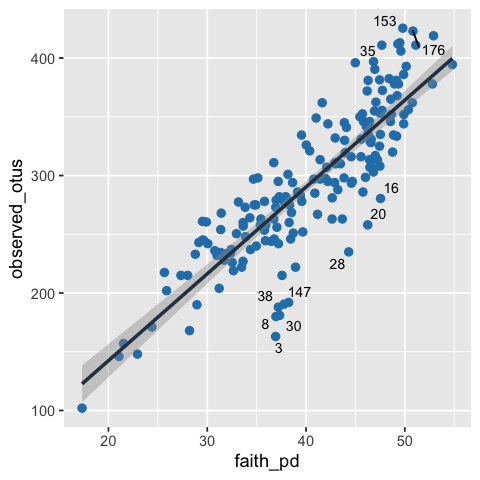

In [7]:
options(repr.plot.width=4, repr.plot.height=4)
adiv2 = adiv_df[rownames(tdata),]
cor(adiv2)
cooksdx <- cooks.distance(lm(observed_otus ~ faith_pd, data=adiv2))
outlyingRows <- cooksdx > (3.7/nrow(adiv2))
sum(outlyingRows)
adiv2$Numbers <- as.character(1:nrow(adiv2))
adiv2[(!outlyingRows), 'Numbers'] <- ""

ggplot(adiv2, aes(x=faith_pd, y=observed_otus, label=Numbers)) + 
  geom_point(color='#2980B9', size = 2) + geom_text_repel(size=3) + # coord_cartesian(xlim = c(0.0, 0.5), ylim = c(0, 0.5)) +
  geom_smooth(method=lm, color='#2C3E50') 




pdf 
  2

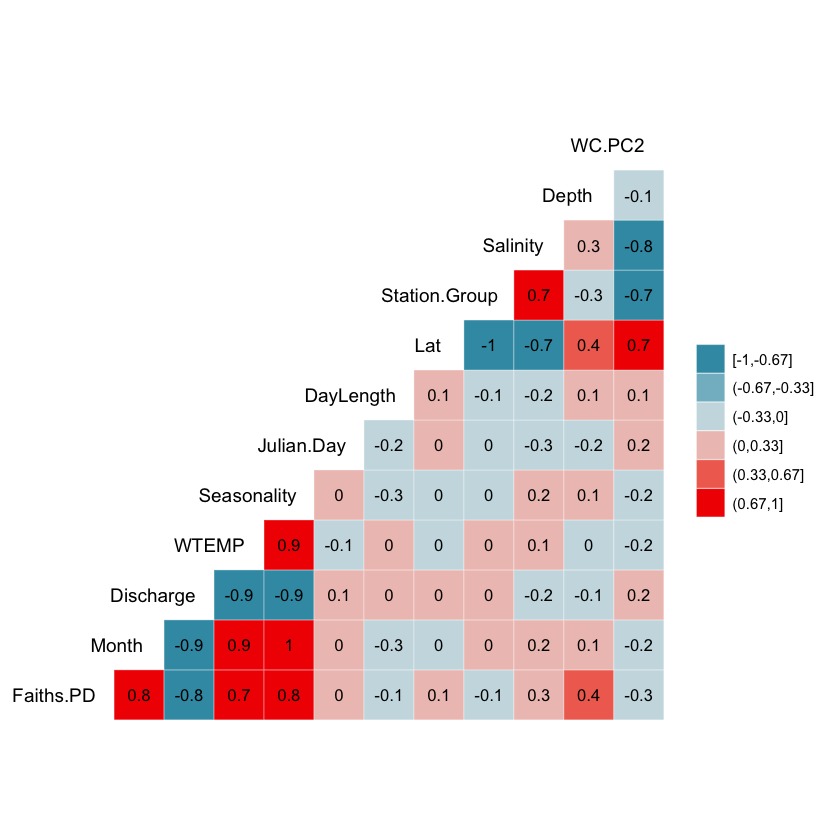

In [8]:
select_cols = c('faith_pd', 'Month','Discharge_Susquehanna_14', 'WTEMP', 'Latitude', 'Depth', 
                'StatName', 'SALINITY', 'anti_day_length', 'AC_PrinComp2', 'julian_day',
                'day_length')

predictors_x = tdata[, select_cols]
# standardize the numeric columns
predictors_ns <- predictors_x %>% mutate_if(is.numeric, list(~ as.numeric(scale(.))) )
names(predictors_ns)[names(predictors_ns) == 'Discharge_Susquehanna_14'] <- 'Discharge'
names(predictors_ns)[names(predictors_ns) == 'anti_day_length'] <- 'Seasonality'
names(predictors_ns)[names(predictors_ns) == 'day_length'] <- 'DayLength'
names(predictors_ns)[names(predictors_ns) == 'julian_day'] <- 'Julian.Day'
names(predictors_ns)[names(predictors_ns) == 'Latitude'] <- 'Lat'
names(predictors_ns)[names(predictors_ns) == 'habitat'] <- 'Habitat'
names(predictors_ns)[names(predictors_ns) == 'SALINITY'] <- 'Salinity'
names(predictors_ns)[names(predictors_ns) == 'StatName'] <- 'Station.Group'
names(predictors_ns)[names(predictors_ns) == 'faith_pd'] <- 'Faiths.PD'
names(predictors_ns)[names(predictors_ns) == 'AC_PrinComp2'] <- 'WC.PC2'

col_order = c('Faiths.PD', 'Month', 'Discharge', 'WTEMP', 'Seasonality', 
              'Julian.Day', 'DayLength', 'Lat', 'Station.Group', 'Salinity', 
              'Depth', 'WC.PC2')

predictors_ns = predictors_ns[,col_order]

# Convert data to numeric
corr <- data.frame(lapply(predictors_ns, as.double))
# Plot the graph
options(repr.plot.width=7, repr.plot.height=7)

png(filename="/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/figs/alpha_div_regression_corr2.png")
ggcorr(corr, method = c("pairwise", "pearson"), nbreaks = 6,
       hjust = 0.92, size=4, label = TRUE, label_size = 3.5, color = "black", layout.exp=1.1)
dev.off()

ggcorr(corr, method = c("pairwise", "pearson"), nbreaks = 6,
       hjust = 0.92, size=4, label = TRUE, label_size = 3.5, color = "black", layout.exp=1.1)

[1] "Habitat"     "WC.PC2"      "PH"          "DO"          "CHLA"       
 [6] "PC"          "PHEO"        "NO3"         "NO2"         "NH4"        
[11] "DOP"         "TP"          "Latitude"    "Seasonality" "Depth"

pdf 
  2

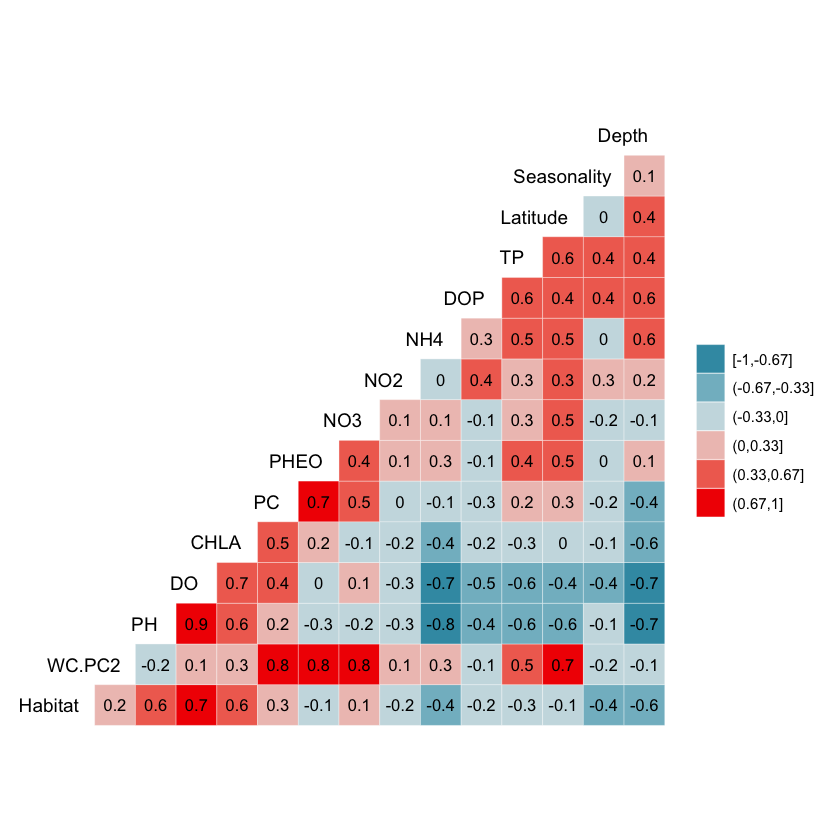

In [9]:
water_chem_cols = c('habitat', 'AC_PrinComp2', 'PH','DO', 'CHLA', 'PC',
                    'PHEO','NO3F', 'NO2F', 'NH4F', 
                    'DOP', 'TP', 'Latitude', 'anti_day_length',
                    'Depth')

predictors_wc = tdata[, water_chem_cols]
# standardize the numeric columns
predictors_wcn <- predictors_wc %>% mutate_if(is.numeric, list(~ as.numeric(scale(.))) )

names(predictors_wcn)[names(predictors_wcn) == 'anti_day_length'] <- 'Seasonality'
names(predictors_wcn)[names(predictors_wcn) == 'habitat'] <- 'Habitat'
names(predictors_wcn)[names(predictors_wcn) == 'AC_PrinComp2'] <- 'WC.PC2'
names(predictors_wcn)[names(predictors_wcn) == 'NO2F'] <- 'NO2'
names(predictors_wcn)[names(predictors_wcn) == 'NO3F'] <- 'NO3'
names(predictors_wcn)[names(predictors_wcn) == 'NH4F'] <- 'NH4'
names(predictors_wcn)

# Convert data to numeric
corr_wc <- data.frame(lapply(predictors_wcn, as.double))
# Plot the graph
options(repr.plot.width=7, repr.plot.height=7)

png(filename="/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/figs/water_chem_correlations.png")
ggcorr(corr_wc, method = c("pairwise", "pearson"), nbreaks = 6,
       hjust = 0.92, size=4, label = TRUE, label_size = 3.5, color = "black", layout.exp=1.1)
dev.off()

ggcorr(corr_wc, method = c("pairwise", "pearson"), nbreaks = 6,
       hjust = 0.92, size=4, label = TRUE, label_size = 3.5, color = "black", layout.exp=1.1)



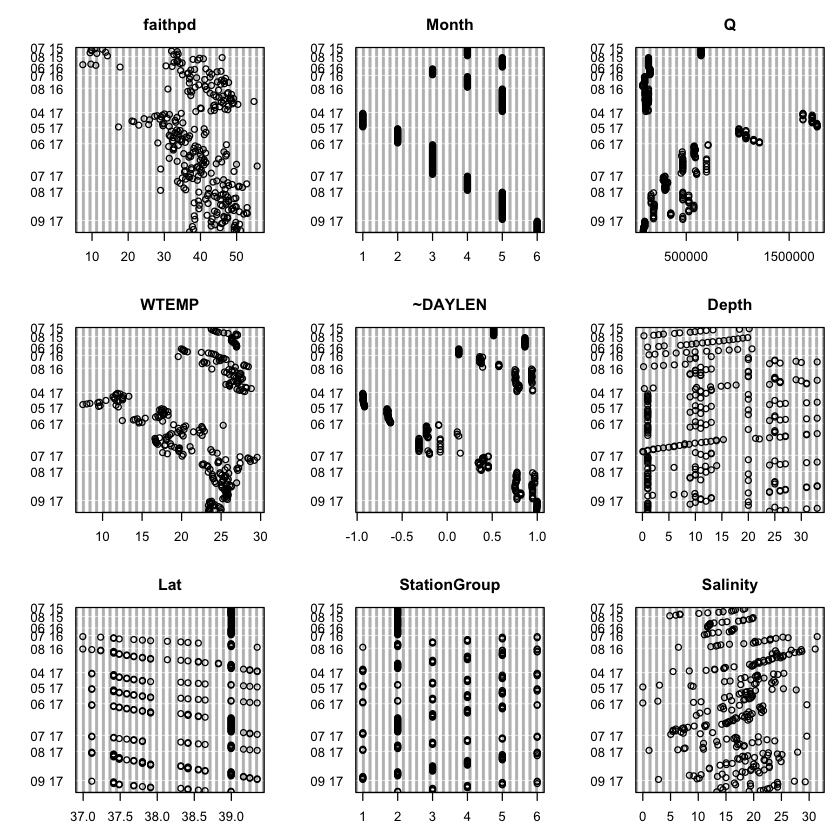

In [10]:
options(repr.plot.width=7, repr.plot.height=7)

op <- par(mfrow = c(3, 3), mar = c(3, 3, 3, 1))
dotchart(fulldata$faith_pd, main = "faithpd", group = fulldata$Month_Year)
dotchart(as.numeric(fulldata$Month), main = "Month", group = fulldata$Month_Year)
dotchart(fulldata$Discharge_Susquehanna_14, main = "Q", group = fulldata$Month_Year)
dotchart(fulldata$WTEMP, main = "WTEMP", group = fulldata$Month_Year)
dotchart(as.numeric(fulldata$anti_day_length), main = "~DAYLEN", group = fulldata$Month_Year)
dotchart(fulldata$Depth, main = "Depth", group = fulldata$Month_Year)
dotchart(fulldata$Latitude, main = "Lat", group = fulldata$Month_Year)
dotchart(as.numeric(fulldata$StatName), main = "StationGroup", group = fulldata$Month_Year)
dotchart(fulldata$SALINITY, main = "Salinity", group = fulldata$Month_Year)
par(op)

[1] 3.490574

[1] 0.3535534

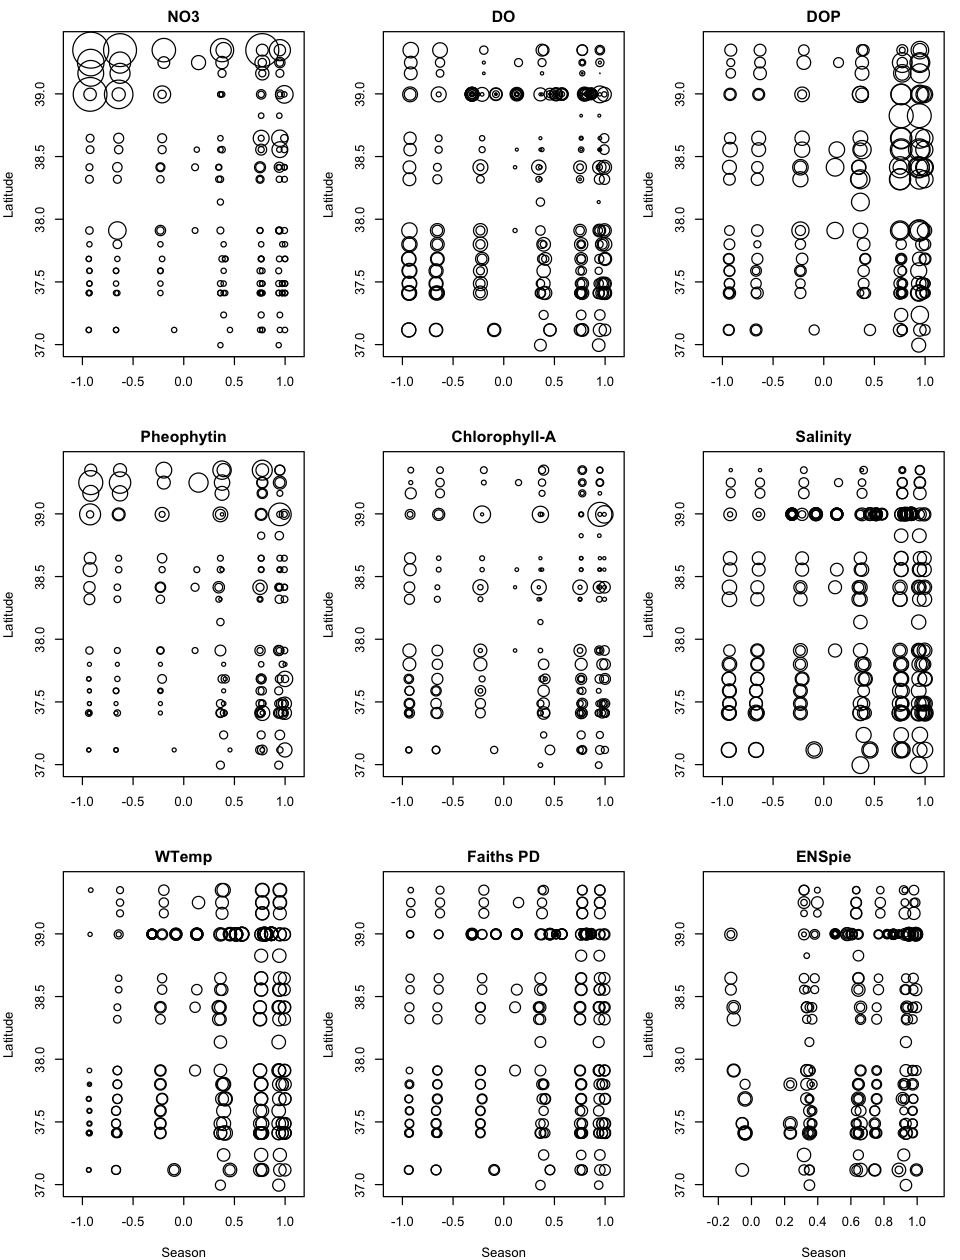

In [11]:
options(repr.plot.width=8, repr.plot.height=7*1.5)

no3size = ((fulldata$NO3F + 0.02)*8)**(0.5)
dosize = ((fulldata$DO + 0.02)*3)**(0.5)
dopsize = ((fulldata$DOP + 0.0001)*3)**(0.5)

op <- par(mfrow = c(3, 3), mar = c(4, 4, 2, 1), cex.lab=1, ann=T)
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=no3size,  main='NO3',
        ylab="Latitude", xlab="", inches=0.15, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=dosize,  main='DO',
        ylab="Latitude", xlab="", inches=0.07, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=dopsize,  main='DOP',
        ylab="Latitude", xlab="", inches=0.1, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))

Pheosize = ((fulldata$PHEO + 0.02)*3)**(0.5)
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=Pheosize,  main='Pheophytin',
        ylab="Latitude", xlab="", inches=0.1, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))

chlasize = ((fulldata$CHLA + 0.02)*3)**(0.5)
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=chlasize,  main='Chlorophyll-A',
        ylab="Latitude", xlab="", inches=0.1, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))

salsize = ((fulldata$SALINITY)*5)**(0.5)
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=salsize, main='Salinity',
        ylab="Latitude", xlab="", inches=0.07, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))

wtempsize = ((fulldata$WTEMP-10)*3)**(0.5)
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=wtempsize, main='WTemp',
        ylab="Latitude", xlab="Season", inches=0.06, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))

pdsize = ((fulldata$faith_pd - min(fulldata$faith_pd) + 0.5)*.25)**(0.5)
max(pdsize); min(pdsize)
symbols(y=fulldata$Latitude, x= fulldata$anti_day_length, circles=pdsize, main='Faiths PD',
        ylab="Latitude", xlab="Season", inches=0.05, ylim=c(37., 39.4), xlim=c(-1.1, 1.1))

enspiesize = ((fulldata$enspie)*2)**(0.5)
symbols(y=fulldata$Latitude, x= fulldata$day_length, circles=enspiesize,  main='ENSpie',
        ylab="Latitude", xlab="Season", inches=0.06, ylim=c(37., 39.4))

par(op)

In [12]:
colnames(fulldata)

[1] "CollectionAgency"         "Year"                    
 [3] "Month"                    "StationName"             
 [5] "Discharge_Susquehanna_14" "day_length"              
 [7] "Latitude"                 "Depth"                   
 [9] "WTEMP"                    "SALINITY"                
[11] "anti_day_length"          "AC_PrinComp2"            
[13] "habitat"                  "Month_Year"              
[15] "depth_float"              "Longitude"               
[17] "julian_day"               "TrimCount"               
[19] "RawCount"                 "DO"                      
[21] "PH"                       "Depth_Percentage"        
[23] "StatName"                 "SalZone"                 
[25] "depth_segment"            "enspie"                  
[27] "faith_pd"                 "TON"                     
[29] "TP"                       "TN"                      
[31] "PN"                       "PP"                      
[33] "PC"                       "TSS"                     
[35] "NO2F"                     "DON"                     
[37] "DIN"                      "NH4F"                    
[39] "NO23F"                    "DOP"                     
[41] "CHLA"                     "NO3F"                    
[43] "PHEO"                     "PO4F"                    
[45] "TDN"                      "TDP"                     
[47] "SIGMA_T"                  "SPCOND"

In [35]:
a_col = 'enspie'
resp_vector = fulldata[!is.na(fulldata[,'CHLA']), a_col]
shapiro.test(resp_vector)
xform_const = powerTransform(lm(resp_vector~1))$lambda
txfm_response = resp_vector^xform_const
shapiro.test(txfm_response)
names(txfm_response) <- rownames(fulldata)[!is.na(fulldata[,'CHLA'])]

active_set = c('Year', 'Month', 'StatName', 'Discharge_Susquehanna_14', 'day_length', 
               'Depth', 'WTEMP', 'anti_day_length', 'AC_PrinComp2', 'TrimCount', 'RawCount',
               'depth_segment', 'habitat', 'SALINITY', 'Latitude', 'PH', 'julian_day',
               'Month_Year', 'DO', 'NO3F', 'NO2F', 'PHEO', 'PC', 'TP', 'DOP')

drop_list = c('Month_Year', 'habitat', 'Month')
active_set = setdiff(active_set, drop_list)

pred_matrix = fulldata[names(txfm_response),]
dim(pred_matrix)
pred_resp = cbind(pred_matrix, txfm_response)
colnames(pred_resp) <- c(colnames(pred_matrix), a_col)
pred_resp_l = pred_resp
pred_resp$Discharge_Susquehanna_14 <- (pred_resp$Discharge_Susquehanna_14 - mean(pred_resp$Discharge_Susquehanna_14))/sd(pred_resp$Discharge_Susquehanna_14)
pred_resp$Latitude <- (pred_resp$Latitude - mean(pred_resp$Latitude))/sd(pred_resp$Latitude)
pred_resp$TP <- (pred_resp$TP - mean(pred_resp$TP))/sd(pred_resp$TP)
pred_resp = subset(pred_resp, select=c(active_set, a_col))

upper_model = lm(enspie ~ ., data=pred_resp)
lower_model = lm(enspie ~ 1, data=pred_resp)
n = length(resid(lower_model))

fbstep_enspie = stepAIC(lower_model, scope=formula(upper_model), scale = 0, direction = 'both', k=log(n), trace=1)
length(colnames(fbstep_enspie$model))
extractAIC(fbstep_enspie)
colnames(fbstep_enspie$model)

# 
# 612



	Shapiro-Wilk normality test

data:  resp_vector
W = 0.98229, p-value = 0.022



	Shapiro-Wilk normality test

data:  txfm_response
W = 0.99286, p-value = 0.5262


[1] 180  48

Start:  AIC=1074.52
enspie ~ 1

                           Df Sum of Sq   RSS    AIC
+ SALINITY                  1   16192.6 52243 1031.1
+ Discharge_Susquehanna_14  1   11186.7 57249 1047.6
+ anti_day_length           1   10726.1 57710 1049.0
+ Latitude                  1    5979.8 62456 1063.2
+ Year                      1    5499.4 62936 1064.6
+ WTEMP                     1    5148.6 63287 1065.6
+ depth_segment             1    4894.0 63542 1066.4
+ AC_PrinComp2              1    4698.7 63737 1066.9
+ NO3F                      1    3343.1 65093 1070.7
+ day_length                1    3067.8 65368 1071.5
+ PC                        1    2853.5 65582 1072.0
<none>                                  68436 1074.5
+ Depth                     1    1869.7 66566 1074.7
+ DO                        1    1647.2 66789 1075.3
+ julian_day                1    1458.3 66977 1075.8
+ NO2F                      1     867.8 67568 1077.4
+ TrimCount                 1     457.6 67978 1078.5
+ RawCount    

[1] 6

[1]   6.0000 974.4282

[1] "enspie"                   "SALINITY"                
[3] "Discharge_Susquehanna_14" "AC_PrinComp2"            
[5] "TP"                       "NO2F"

In [36]:
eM1 <- lm(enspie~SALINITY + Discharge_Susquehanna_14 + AC_PrinComp2, data=pred_resp)
eM2 <- lm(enspie~SALINITY + Discharge_Susquehanna_14*AC_PrinComp2, data=pred_resp)
eM3 <- lm(enspie~SALINITY*Discharge_Susquehanna_14 + AC_PrinComp2, data=pred_resp)
eM4 <- lm(enspie~SALINITY*AC_PrinComp2 + Discharge_Susquehanna_14, data=pred_resp)
anova(eM1, eM2, eM3, eM4)
summary(eM1)
drop1(eM1, test="F")


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
176,40805.05,NA,NA,NA,NA
175,40618.72,1,186.3333,0.8027906,0.3714912
175,40062.53,0,556.1898,NA,NA
175,40729.87,0,-667.3384,NA,NA



Call:
lm(formula = enspie ~ SALINITY + Discharge_Susquehanna_14 + AC_PrinComp2, 
    data = pred_resp)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.167  -9.082   0.694  10.428  33.157 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                7.7812     5.5848   1.393    0.165    
SALINITY                   2.3725     0.3005   7.895 3.00e-13 ***
Discharge_Susquehanna_14  -7.2351     1.1719  -6.174 4.48e-09 ***
AC_PrinComp2               4.5858     1.0652   4.305 2.77e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.23 on 176 degrees of freedom
Multiple R-squared:  0.4037,	Adjusted R-squared:  0.3936 
F-statistic: 39.73 on 3 and 176 DF,  p-value: < 2.2e-16


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,40805.05,984.2488,NA,NA
SALINITY,1,14450.523,55255.58,1036.8182,62.32787,2.998497e-13
Discharge_Susquehanna_14,1,8836.583,49641.63,1017.5331,38.11387,4.478134e-09
AC_PrinComp2,1,4296.593,45101.65,1000.2691,18.53203,2.768805e-05


In [37]:
options(repr.plot.width=4, repr.plot.height=3)

vf3 <- varPower(form= ~ Latitude)

evM5 <- gls(enspie~ SALINITY + Discharge_Susquehanna_14 + AC_PrinComp2, data=pred_resp, weights=vf3)

envM1 <- gam(enspie~ s(SALINITY, bs = "cs")  + s(Discharge_Susquehanna_14, bs = "cs")
             + s(AC_PrinComp2, bs = "cs"), data=pred_resp)
envM2 <- gam(enspie~ s(SALINITY, bs = "cs")  + s(Discharge_Susquehanna_14, bs = "cs")
                       + s(TP, bs = "cs"), data=pred_resp)

envM3 <- gamm(enspie~ s(SALINITY, bs = "cs") + s(Discharge_Susquehanna_14, bs = "cs")
              + s(AC_PrinComp2, bs = "cs"), weights=vf3, data=pred_resp)
envM4 <- gamm(enspie~ s(SALINITY, bs = "cs")  + s(Discharge_Susquehanna_14, bs = "cs") 
                        + s(TP, bs = "cs"), weights=vf3, data=pred_resp)
#summary(evM5)
#summary(envM1)
summary(envM2)
#summary(envM3$gam)
#summary(envM4$gam)
#AIC(envM2)
#AIC(envM4$lme)
#plot(envM3$gam)
coef(envM2)


Family: gaussian 
Link function: identity 

Formula:
enspie ~ s(SALINITY, bs = "cs") + s(Discharge_Susquehanna_14, 
    bs = "cs") + s(TP, bs = "cs")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   50.952      1.015   50.22   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                              edf Ref.df     F  p-value    
s(SALINITY)                 6.148      9 6.802 1.08e-10 ***
s(Discharge_Susquehanna_14) 5.040      9 2.707 0.000162 ***
s(TP)                       3.427      9 1.705 0.001440 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.515   Deviance explained = 55.5%
GCV =  202.9  Scale est. = 185.3     n = 180

(Intercept)                 s(SALINITY).1 
                 50.952482218                   4.799027558 
                s(SALINITY).2                 s(SALINITY).3 
                  0.001631139                   1.469682851 
                s(SALINITY).4                 s(SALINITY).5 
                  2.672642119                   6.019570098 
                s(SALINITY).6                 s(SALINITY).7 
                  7.979812488                   9.834014737 
                s(SALINITY).8                 s(SALINITY).9 
                 25.782395212                  20.839774307 
s(Discharge_Susquehanna_14).1 s(Discharge_Susquehanna_14).2 
                  3.842775079                   3.654152197 
s(Discharge_Susquehanna_14).3 s(Discharge_Susquehanna_14).4 
                 -3.510294119                  -7.108423337 
s(Discharge_Susquehanna_14).5 s(Discharge_Susquehanna_14).6 
                 -2.823494360                  -3.635601856 
s(Discharge_Susquehanna_14).7 s(Discharge_Susquehanna_14).8 
                 -0.219568607                  -5.352912787 
s(Discharge_Susquehanna_14).9                       s(TP).1 
                -13.059338062                  -2.184517746 
                      s(TP).2                       s(TP).3 
                 -1.135225081                   0.628992903 
                      s(TP).4                       s(TP).5 
                  3.304229159                   6.648784802 
                      s(TP).6                       s(TP).7 
                  8.711146750                   8.290987885 
                      s(TP).8                       s(TP).9 
                 -0.155981871                  -2.051655985


	Shapiro-Wilk normality test

data:  resid(envM2)
W = 0.99233, p-value = 0.4611


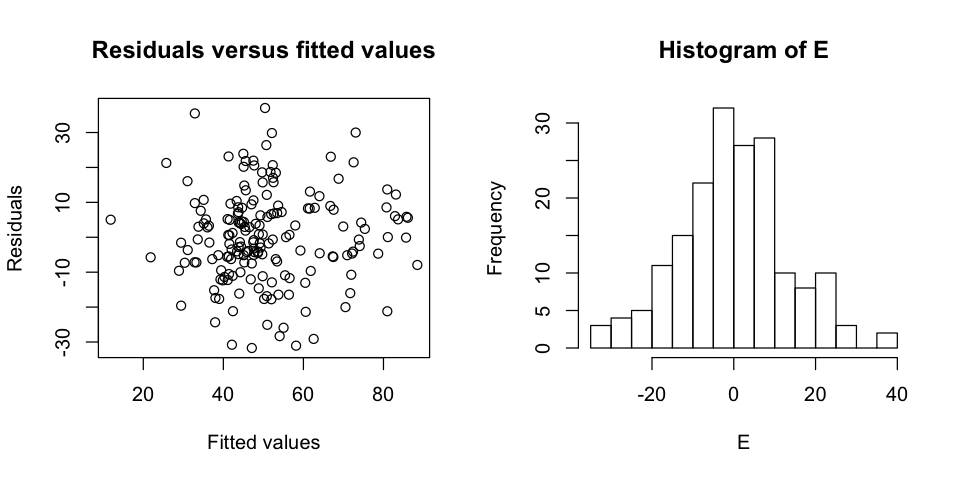

In [16]:
options(repr.plot.width=8, repr.plot.height=4)
shapiro.test(resid(envM2))

E <- resid(envM2)
Fit <- fitted(envM2)
op <- par(mfrow = c(1, 2))
plot(x = Fit,y = E, xlab = "Fitted values", ylab = "Residuals", main = "Residuals versus fitted values")
hist(E, nclass = 15)
par(op)

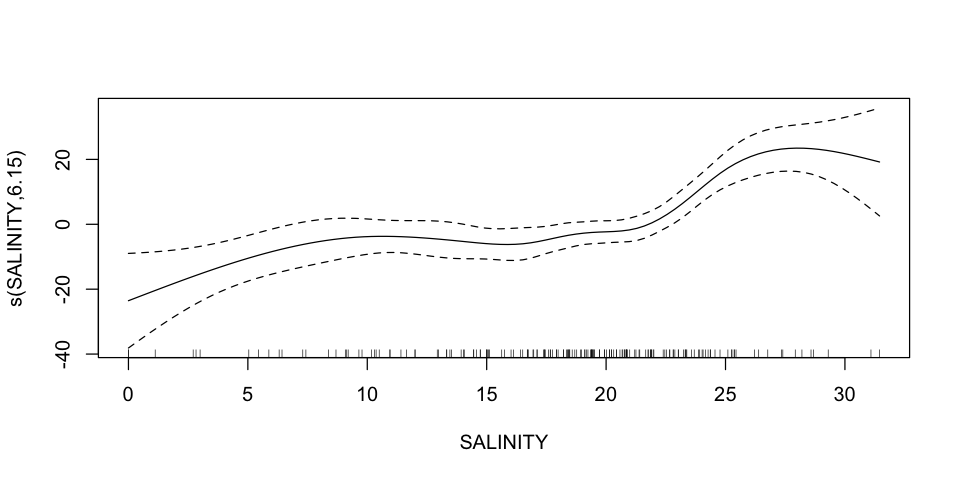

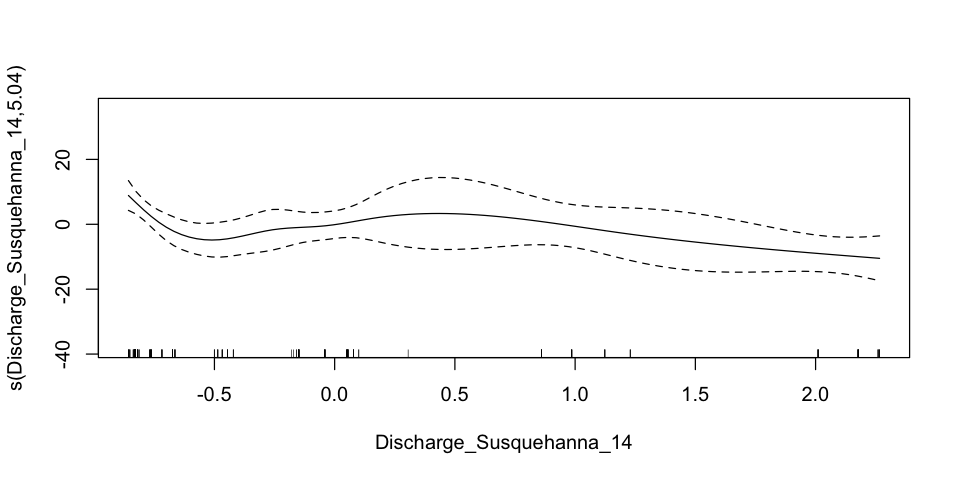

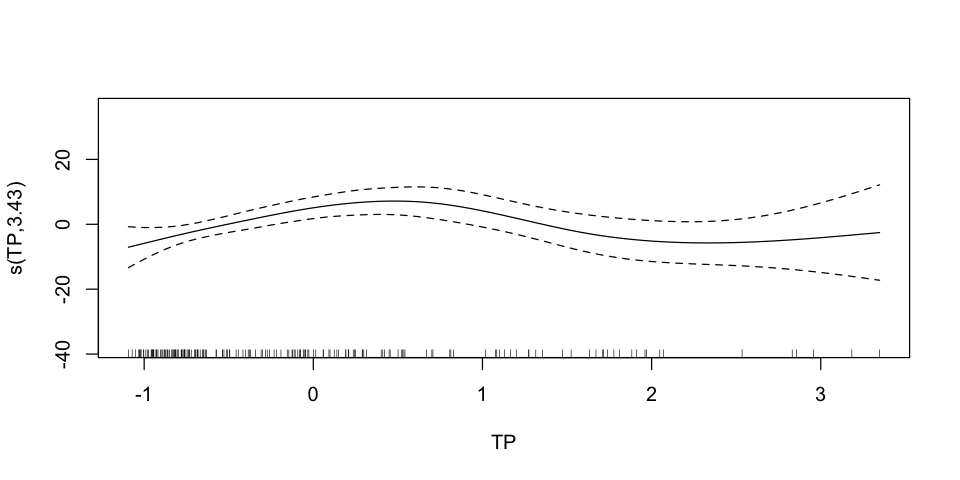

In [17]:
plot(envM2)

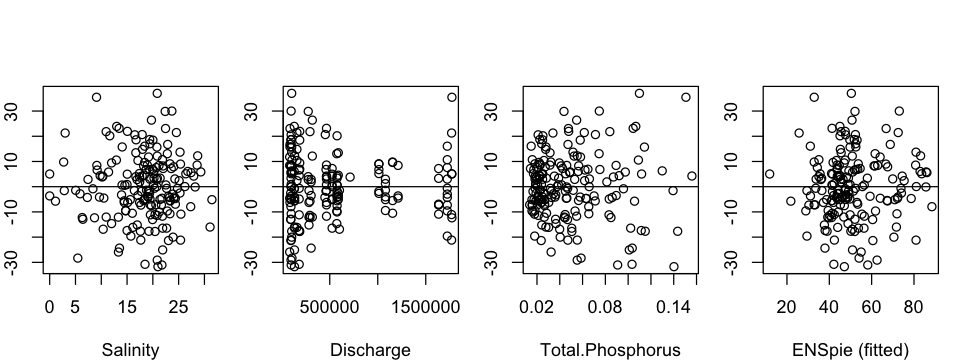

In [18]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow = c(1, 4), mar=c(4,2,4,1), cex=0.9)
eE2 <- resid(envM2)
plot(y = eE2, x = pred_resp_l$SALINITY, xlab = "Salinity", ylab = "Residuals")
abline(0,0)
plot(eE2 ~ pred_resp_l$Discharge_Susquehanna_14, xlab = "Discharge", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ pred_resp_l$TP, xlab = "Total.Phosphorus", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ Fit, xlab = "ENSpie (fitted)", ylab = "Residuals")
abline(0, 0)
par(op)

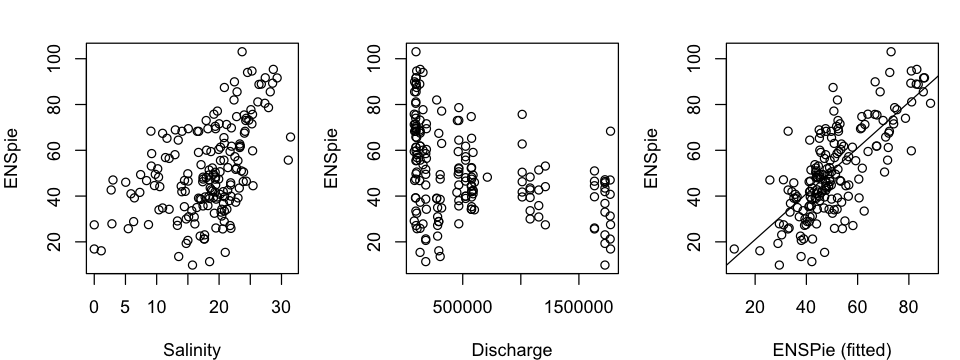

In [19]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow = c(1, 3), mar=c(4,4,2,1), cex=0.9)
plot(y = pred_resp_l$enspie, x = pred_resp_l$SALINITY, xlab = "Salinity", ylab = "ENSpie")
abline(0,0)
plot(pred_resp_l$enspie ~ pred_resp_l$Discharge_Susquehanna_14, xlab = "Discharge", ylab = "ENSpie")
abline(v=-0.6)
abline(v=-0.3)
abline(v=0.5)
abline(v=1.5)
plot(pred_resp_l$enspie ~ Fit, xlab = "ENSPie (fitted)", ylab = "ENSpie")
abline(1, 1)
par(op)


(0.56, 0.65)  (0.64, 0.7)  (1.3, 1.38) (1.38, 1.46) (1.46, 1.52) (1.52, 1.64) 
          32           26           46           38           36           44 
 (1.63, 1.7) (1.69, 1.76)        <0.57        >1.75 
          44           36           24           34 

[1] "(0.56, 0.65)" "(0.64, 0.7)"  "(1.3, 1.38)"  "(1.38, 1.46)" "(1.46, 1.52)"
 [6] "(1.52, 1.64)" "(1.63, 1.7)"  "(1.69, 1.76)" "<0.57"        ">1.75"

[1] "<0.57"        "(0.56, 0.65)" "(0.64, 0.7)"  "(1.3, 1.38)"  "(1.38, 1.46)"
 [6] "(1.46, 1.52)" "(1.52, 1.64)" "(1.63, 1.7)"  "(1.69, 1.76)" ">1.75"

Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”

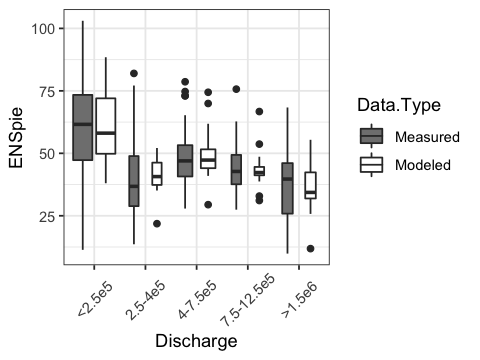

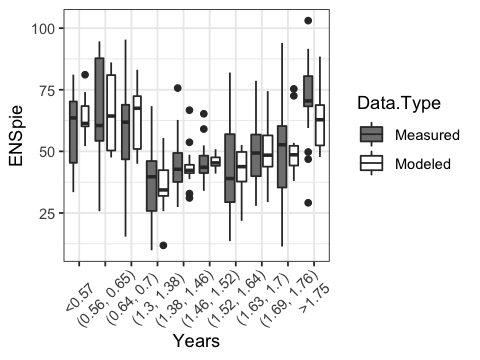

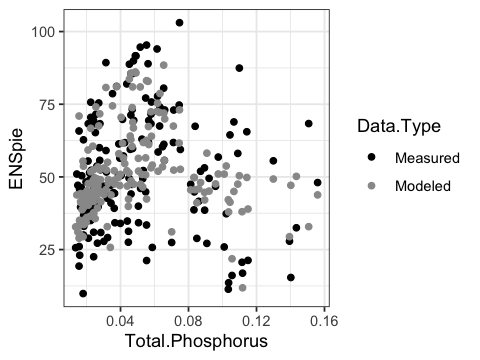

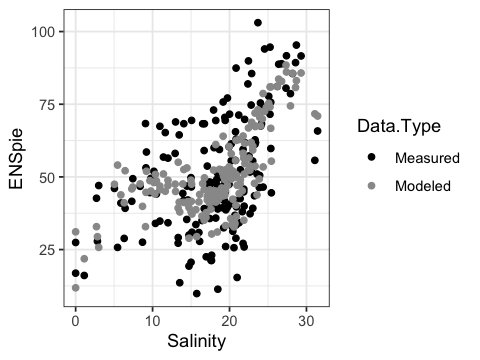

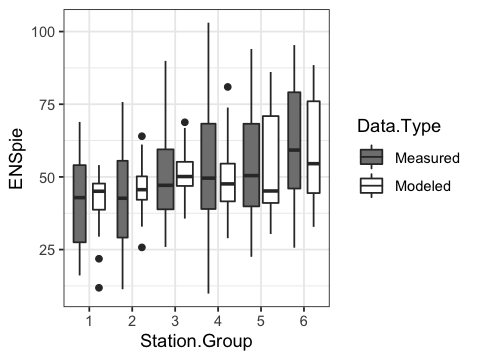

In [25]:
library(ggplot2)

#stat_density_2d(aes(fill = after_stat(level)), geom = "polygon") + scale_fill_grey)_

obs_df = pred_resp_l[,c('SALINITY', 'Discharge_Susquehanna_14', 'TP', 'StatName', 'enspie', 'julian_day')]
colnames(obs_df)[colnames(obs_df) == 'Discharge_Susquehanna_14'] = 'Discharge'
colnames(obs_df)[colnames(obs_df) == 'TP'] = 'Total.Phosphorus'
colnames(obs_df)[colnames(obs_df) == 'SALINITY'] = 'Salinity'
colnames(obs_df)[colnames(obs_df) == 'StatName'] = 'Station.Group'
colnames(obs_df)[colnames(obs_df) == 'julian_day'] = 'Julian.Day'
colnames(obs_df)[colnames(obs_df) == 'enspie'] = 'ENSpie'

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
mod_df[,'ENSpie'] <- predict(envM2)

obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)

obsmod_df$DischargeFactor <- NA
obdfD = obsmod_df$Discharge
obsmod_df[ obdfD < 250000,'DischargeFactor'] = '<2.5e5'
obsmod_df[(obdfD > 250000) & (obdfD < 400000), 'DischargeFactor'] = '2.5-4e5'
obsmod_df[(obdfD > 400000) & (obdfD < 750000), 'DischargeFactor'] = '4-7.5e5'
obsmod_df[(obdfD > 750000) & (obdfD < 1250000), 'DischargeFactor'] = '7.5-12.5e5'
obsmod_df[ obdfD > 1500000,'DischargeFactor'] = '>1.5e6'
obsmod_df$Discharge = factor(obsmod_df$DischargeFactor, 
                             levels = c('<2.5e5', '2.5-4e5', '4-7.5e5', '7.5-12.5e5', '>1.5e6'))


obsmod_df$JDF <- NA
obdfJD = obsmod_df$Julian.Day
obsmod_df[ (obdfJD < 572), 'JDF'] <- paste('<', toString(round((572-365)/365, 2)), sep="")
obsmod_df[ (obdfJD > 571) & (obdfJD < 601), 'JDF'] <- paste('(', toString(round((571-365)/365, 2)), ", ", toString(round((601-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 600) & (obdfJD < 621), 'JDF'] <- paste('(', toString(round((600-365)/365, 2)), ", ", toString(round((621-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 841) & (obdfJD < 870), 'JDF'] <- paste('(', toString(round((841-365)/365, 2)), ", ", toString(round((870-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 869) & (obdfJD < 899), 'JDF'] <- paste('(', toString(round((869-365)/365, 2)), ", ", toString(round((899-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 898) & (obdfJD < 919), 'JDF'] <- paste('(', toString(round((898-365)/365, 2)), ", ", toString(round((919-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 918) & (obdfJD < 962), 'JDF'] <- paste('(', toString(round((918-365)/365, 2)), ", ", toString(round((962-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 961) & (obdfJD < 984), 'JDF'] <- paste('(', toString(round((961-365)/365, 2)), ", ", toString(round((984-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 983) & (obdfJD < 1006), 'JDF'] <- paste('(', toString(round((983-365)/365, 2)), ", ", toString(round((1006-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 1005), 'JDF'] <- paste('>', toString(round((1005-365)/365, 2)), sep="")
table(obsmod_df$JDF)
obsmod_df$Years = factor(obsmod_df$JDF)
jdf_levels = levels(obsmod_df$Years)
jdf_levels
jdf_levels = c(jdf_levels[length(jdf_levels)-1], 
               jdf_levels[1:(length(jdf_levels)-2)], 
               jdf_levels[length(jdf_levels)])
jdf_levels
obsmod_df$Years <- factor(obsmod_df$Years, levels = jdf_levels)

options(repr.plot.width=4, repr.plot.height=3)
bp <- ggplot(obsmod_df, aes(x=Discharge, y=ENSpie, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp2 <- ggplot(obsmod_df, aes(x=Total.Phosphorus, y=ENSpie, color=Data.Type)) + 
       geom_point() + scale_color_grey(start=0., end=0.6) + theme_bw()


bp3 <- ggplot(obsmod_df, aes(x=Salinity, y=ENSpie, color=Data.Type)) + 
       geom_point() + scale_color_grey(start=0., end=0.6) + theme_bw()

bp4 <- ggplot(obsmod_df, aes(x=Station.Group, y=ENSpie, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + theme_bw()

bp1 <- ggplot(obsmod_df, aes(x=Years, y=ENSpie, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp
bp1
bp2
bp3
bp4



In [26]:
qbymy = aggregate(fulldata$Discharge_Susquehanna_14, by=list(fulldata$Month_Year), FUN=mean)
qbymy$y = qbymy$x < 2.5e5
#qbymy$x <- scale(qbymy$x)
qbymy 

Group.1,x,y
<fct>,<dbl>,<lgl>
07 15,643638.61,FALSE
08 15,133004.38,TRUE
06 16,147550.83,TRUE
07 16,90970.65,TRUE
08 16,115047.47,TRUE
04 17,1715125.09,FALSE
05 17,1085844.03,FALSE
06 17,552495.42,FALSE
07 17,294291.00,FALSE


[1] 172   8



	Shapiro-Wilk normality test

data:  resp_vector
W = 0.9555, p-value = 2.866e-05



	Shapiro-Wilk normality test

data:  txfm_response
W = 0.96471, p-value = 0.000238


Start:  AIC=679.95
faith_pd ~ 1

                           Df Sum of Sq    RSS    AIC
+ anti_day_length           1    5767.5 2929.6 497.94
+ Month                     5    5780.2 2917.0 517.78
+ Month_Year                7    5827.9 2869.3 525.24
+ Discharge_Susquehanna_14  1    5223.0 3474.2 527.26
+ WTEMP                     1    4152.8 4544.4 573.45
+ DO                        1    3560.2 5136.9 594.53
+ habitat                   2    2809.6 5887.5 623.13
+ DOP                       1    2228.7 6468.4 634.17
+ TP                        1    2072.1 6625.1 638.29
+ Depth                     1    1341.4 7355.8 656.28
+ depth_segment             1    1245.9 7451.2 658.50
+ NO2F                      1     912.8 7784.4 666.02
+ PC                        1     838.3 7858.9 667.66
+ SALINITY                  1     730.1 7967.1 670.01
+ Year                      1     693.0 8004.1 670.81
+ NO3F                      1     545.3 8151.8 673.96
+ AC_PrinComp2              1     432.3 8264.8 67

[1] 5

[1]   5.0000 404.6403

[1] "faith_pd"        "anti_day_length" "DO"              "SALINITY"       
[5] "julian_day"

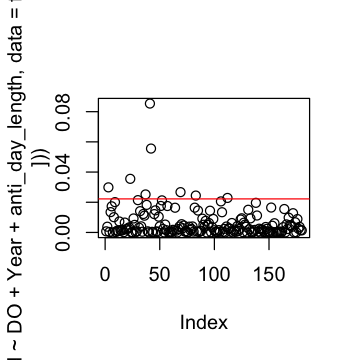

In [27]:
library(MASS)
options(repr.plot.width=3, repr.plot.height=3)
a_col = 'faith_pd'
resp_vector = fulldata[!is.na(fulldata[,'CHLA']), a_col]

names(resp_vector) <- rownames(fulldata)[!is.na(fulldata[,'CHLA'])]

plot(cooks.distance(lm(faith_pd ~ DO + Year + anti_day_length, data=fulldata[names(resp_vector),])))

abline(h = 4/length(resp_vector), col="red")

outlierfind = cooks.distance(lm(faith_pd ~ DO + Year + anti_day_length, data=fulldata[names(resp_vector),]))

outliersfound = names(outlierfind)[outlierfind > 4/length(resp_vector)]

resp_vector = resp_vector[!(names(resp_vector) %in% outliersfound)]
print(c(length(resp_vector), length(outliersfound)))
shapiro.test(resp_vector)
xform_constL = powerTransform(lm(resp_vector~1))$lambda
txfm_response = scale(resp_vector^xform_constL)
shapiro.test(txfm_response)


names(txfm_response) <- names(resp_vector)
active_set = c('Year', 'Month', 'StatName', 'Discharge_Susquehanna_14', 'day_length', 
               'Depth', 'WTEMP', 'anti_day_length', 'AC_PrinComp2', 'TrimCount', 'RawCount',
               'depth_segment', 'habitat', 'SALINITY', 'Latitude', 'PH', 'julian_day',
               'Month_Year', 'DO', 'NO3F', 'NO2F', 'PHEO', 'PC', 'TP', 'DOP')

drop_list = c('RawCount', 'PH')
active_set = setdiff(active_set, drop_list)

pred_matrix = fulldata[names(txfm_response),]
pred_resp = cbind.data.frame(pred_matrix, txfm_response)
colnames(pred_resp) <- c(colnames(pred_matrix), a_col)

pred_resp_l = pred_resp

pred_resp$DO <- (pred_resp$DO - mean(pred_resp$DO))/sd(pred_resp$DO)
pred_resp$SALINITY <- (pred_resp$SALINITY - mean(pred_resp$SALINITY))/sd(pred_resp$SALINITY)
pred_resp$julian_day <- (pred_resp$julian_day - mean(pred_resp$julian_day))/sd(pred_resp$julian_day)
pred_resp$anti_day_length <- (pred_resp$anti_day_length - mean(pred_resp$anti_day_length))/sd(pred_resp$anti_day_length)
pred_resp = subset(pred_resp, select=c(active_set, a_col))

upper_model = lm(faith_pd ~ ., data=pred_resp)
lower_model = lm(faith_pd ~ 1, data=pred_resp)
n = length(resid(lower_model))

fbstep_enspie = stepAIC(lower_model, scope=formula(upper_model), scale = 0, direction = 'both', k=log(n), trace=1)
length(colnames(fbstep_enspie$model))
extractAIC(fbstep_enspie)
colnames(fbstep_enspie$model)


In [28]:
fM2 <- lm(faith_pd ~ julian_day + DO + anti_day_length + SALINITY , data = pred_resp)
vif(fM2)
anova(fM2)
summary(fM2)

julian_day              DO anti_day_length        SALINITY 
       1.135082        1.278902        1.230313        1.107375

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
julian_day,1,1.509817e-02,1.509817e-02,1.477945e-03,9.693796e-01
DO,1,3.757006e+03,3.757006e+03,3.677696e+02,4.623503e-44
anti_day_length,1,3.099370e+03,3.099370e+03,3.033943e+02,2.137962e-39
SALINITY,1,1.347528e+02,1.347528e+02,1.319081e+01,3.739513e-04
Residuals,167,1.706014e+03,1.021565e+01,NA,NA



Call:
lm(formula = faith_pd ~ julian_day + DO + anti_day_length + SALINITY, 
    data = pred_resp)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.7457 -2.0997 -0.0392  2.3859  8.3908 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      40.4510     0.2437 165.982  < 2e-16 ***
julian_day        0.7210     0.2604   2.769 0.006263 ** 
DO               -2.7664     0.2764 -10.009  < 2e-16 ***
anti_day_length   4.5350     0.2711  16.728  < 2e-16 ***
SALINITY          0.9342     0.2572   3.632 0.000374 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.196 on 167 degrees of freedom
Multiple R-squared:  0.8038,	Adjusted R-squared:  0.7991 
F-statistic: 171.1 on 4 and 167 DF,  p-value: < 2.2e-16


In [34]:
#vf4 <- varPower(form = ~ Latitude)
#vf4 <- varExp(form =~ Latitude)

#vf4 <- varConstPower(form = ~ Latitude)
vf4 <- varIdent(form= ~1 | Month_Year)

fA2 <- gam(faith_pd ~ s(julian_day, bs='cs') + s(DO, bs='cs') + s(anti_day_length, bs='cs') + 
                       s(SALINITY, bs='cs'), data = pred_resp_l)

fAM2 <- gamm(faith_pd ~ s(julian_day, bs='cs') + s(DO, bs='cs') + 
                        s(SALINITY, bs='cs') + s(anti_day_length, bs='cs'), 
                        data = pred_resp_l, weights = vf4)

mean((pred_resp$faith_pd - predict(fA2))^2)
mean((pred_resp$faith_pd - predict(fAM2$gam))^2)


summary(fA2)
summary(fAM2$gam)
anova(fA2)
coef(fA2)

[1] 7.757326

[1] 9.720889


Family: gaussian 
Link function: identity 

Formula:
faith_pd ~ s(julian_day, bs = "cs") + s(DO, bs = "cs") + s(anti_day_length, 
    bs = "cs") + s(SALINITY, bs = "cs")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  40.4510     0.2238   180.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df     F  p-value    
s(julian_day)      1.564      9 0.537   0.0426 *  
s(DO)              2.664      9 6.622 2.10e-13 ***
s(anti_day_length) 6.574      9 7.568 1.14e-12 ***
s(SALINITY)        5.291      9 4.186 4.62e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.831   Deviance explained = 84.7%
GCV = 9.5637  Scale est. = 8.6133    n = 172


Family: gaussian 
Link function: identity 

Formula:
faith_pd ~ s(julian_day, bs = "cs") + s(DO, bs = "cs") + s(SALINITY, 
    bs = "cs") + s(anti_day_length, bs = "cs")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  40.5350     0.2373   170.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df      F  p-value    
s(julian_day)      0.830      9  0.392 0.032495 *  
s(DO)              1.961      9  8.305  < 2e-16 ***
s(SALINITY)        1.179      9  1.565 0.000122 ***
s(anti_day_length) 3.071      9 28.856  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.82   
  Scale est. = 12.414    n = 172


Family: gaussian 
Link function: identity 

Formula:
faith_pd ~ s(julian_day, bs = "cs") + s(DO, bs = "cs") + s(anti_day_length, 
    bs = "cs") + s(SALINITY, bs = "cs")

Approximate significance of smooth terms:
                     edf Ref.df     F  p-value
s(julian_day)      1.564  9.000 0.537   0.0426
s(DO)              2.664  9.000 6.622 2.10e-13
s(anti_day_length) 6.574  9.000 7.568 1.14e-12
s(SALINITY)        5.291  9.000 4.186 4.62e-07

(Intercept)      s(julian_day).1      s(julian_day).2 
         40.45099265          -0.55102518          -1.26507629 
     s(julian_day).3      s(julian_day).4      s(julian_day).5 
         -0.34976423          -0.28236630           0.04911917 
     s(julian_day).6      s(julian_day).7      s(julian_day).8 
          0.28074296           0.76930099           1.18957875 
     s(julian_day).9              s(DO).1              s(DO).2 
          1.52754533           1.59834227          -0.15766260 
             s(DO).3              s(DO).4              s(DO).5 
         -0.49905755          -1.18963552          -1.89395842 
             s(DO).6              s(DO).7              s(DO).8 
         -2.94440549          -2.19730791          -4.47750178 
             s(DO).9 s(anti_day_length).1 s(anti_day_length).2 
         -5.82542912          -3.22638697          -2.27415661 
s(anti_day_length).3 s(anti_day_length).4 s(anti_day_length).5 
          1.55637035           1.94461602           2.12082089 
s(anti_day_length).6 s(anti_day_length).7 s(anti_day_length).8 
          6.66983419           6.57831836           5.65798589 
s(anti_day_length).9        s(SALINITY).1        s(SALINITY).2 
          6.28249160           2.29441410          -0.13286455 
       s(SALINITY).3        s(SALINITY).4        s(SALINITY).5 
          0.60157544           1.30891911           2.41354279 
       s(SALINITY).6        s(SALINITY).7        s(SALINITY).8 
          3.94170360           2.68972947           5.33419323 
       s(SALINITY).9 
         -2.78491081

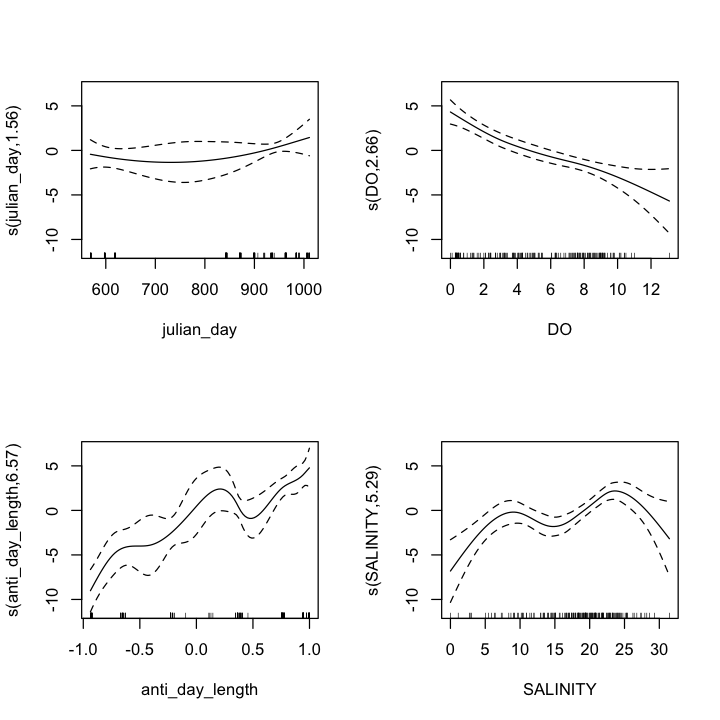

In [30]:
options(repr.plot.width=6, repr.plot.height=6)
op <- par(mfrow = c(2, 2))
plot(fA2)


	Shapiro-Wilk normality test

data:  fE2
W = 0.99422, p-value = 0.7374


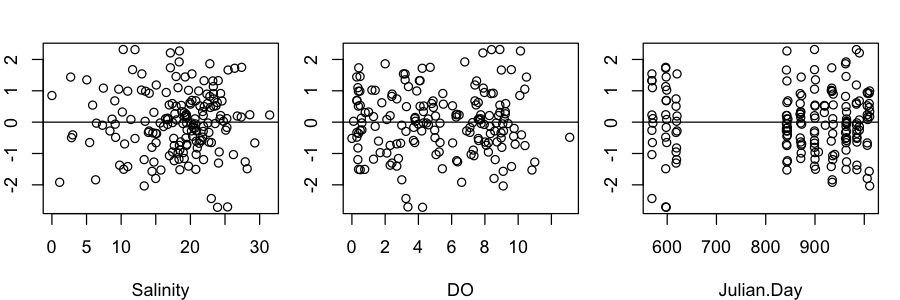

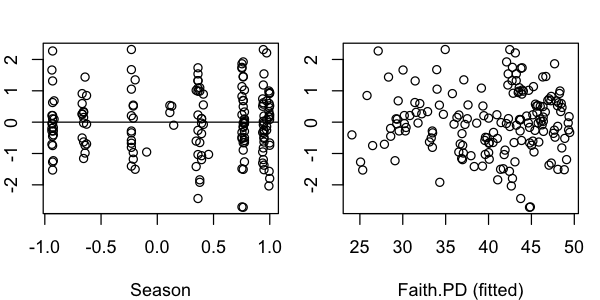

In [31]:

options(repr.plot.width=7.5, repr.plot.height=2.5)
par(mfrow = c(1, 3), mar=c(4,2,2,1), cex=0.9)
fE2 <- scale(resid(fA2))
Fit.fA2 <- fitted(fA2)
shapiro.test(fE2)
plot(y = fE2, x = pred_resp_l[,'SALINITY'], xlab = "Salinity", ylab = "Residuals")
abline(0,0)
plot(fE2 ~ pred_resp_l[,'DO'], xlab = "DO", ylab = "Residuals")
abline(0, 0)
plot(fE2 ~ pred_resp_l[,'julian_day'], xlab = "Julian.Day", ylab = "Residuals")
abline(0, 0)
par(op)

options(repr.plot.width=5, repr.plot.height=2.5)
par(mfrow = c(1, 2), mar=c(4,2,2,1), cex=0.9)
plot(fE2 ~ pred_resp_l[,'anti_day_length'], xlab = "Season", ylab = "Residuals")
abline(0, 0)
plot(fE2 ~ Fit.fA2, xlab = "Faith.PD (fitted)", ylab = "Residuals")
abline(1, 1)
par(op)




Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 14 iterations.
The RMS GCV score gradient at convergence was 0.000178263 .
The Hessian was positive definite.
Model rank =  37 / 37 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                     k'  edf k-index p-value
s(julian_day)      9.00 1.56    1.10    0.89
s(DO)              9.00 2.66    1.01    0.50
s(anti_day_length) 9.00 6.57    1.07    0.81
s(SALINITY)        9.00 5.29    1.12    0.91


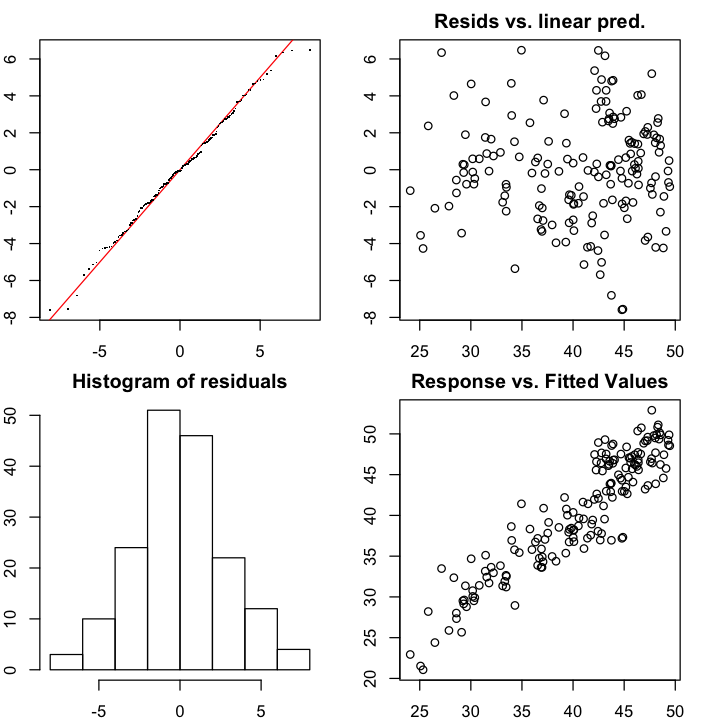

In [32]:
options(repr.plot.width=6, repr.plot.height=6)
par(mar = c(2, 2, 2, 2))
gam.check(fA2)


(0.56, 0.65)  (0.64, 0.7)  (1.3, 1.38) (1.38, 1.46) (1.46, 1.52) (1.52, 1.64) 
          30           22           44           34           36           42 
 (1.63, 1.7) (1.69, 1.76)        <0.57        >1.75 
          44           36           22           34 

[1] "(0.56, 0.65)" "(0.64, 0.7)"  "(1.3, 1.38)"  "(1.38, 1.46)" "(1.46, 1.52)"
 [6] "(1.52, 1.64)" "(1.63, 1.7)"  "(1.69, 1.76)" "<0.57"        ">1.75"

[1] "<0.57"        "(0.56, 0.65)" "(0.64, 0.7)"  "(1.3, 1.38)"  "(1.38, 1.46)"
 [6] "(1.46, 1.52)" "(1.52, 1.64)" "(1.63, 1.7)"  "(1.69, 1.76)" ">1.75"


    (-0.5, 0) (-0.75, -0.5)      (0, 0.5)   (0.5, 0.85)       < -0.75 
           36            34            64            74            44 
       > 0.85 
           92 

Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”Warning message:
“Can't preserve total widths when varwidth = TRUE.”

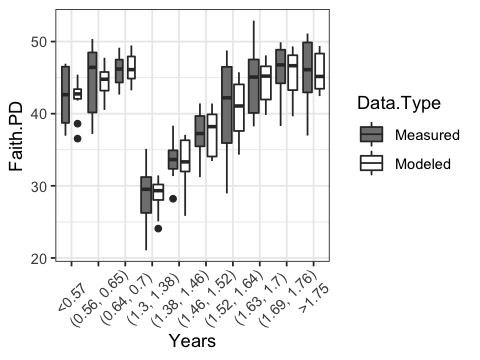

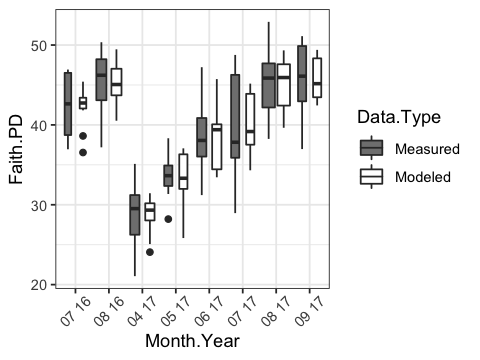

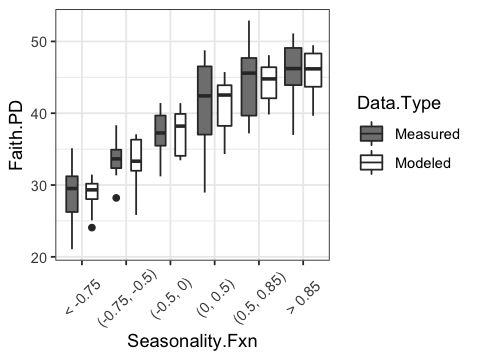

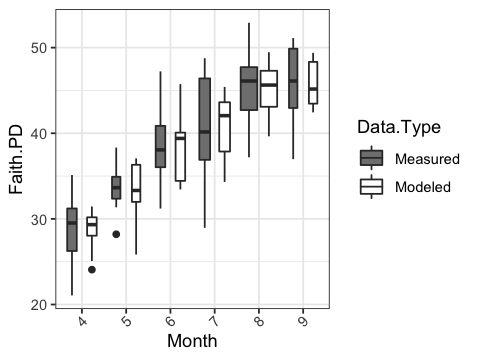

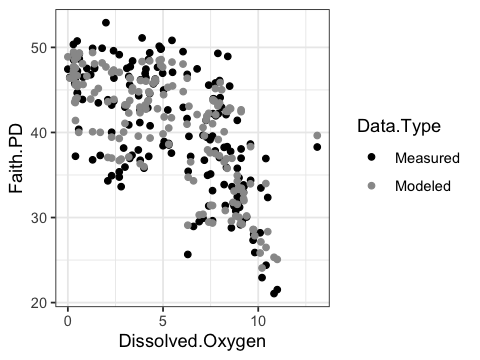

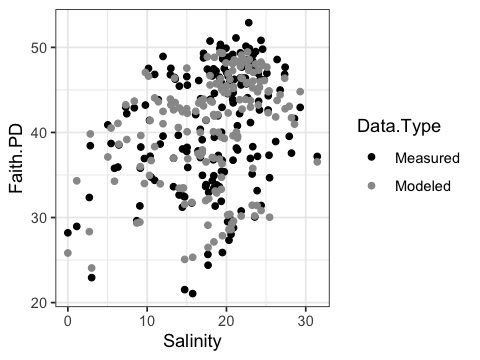

In [33]:
library(ggplot2)

obs_df = pred_resp_l[,c('julian_day', 'DO', 'SALINITY', 'anti_day_length', 
                        'faith_pd', 'Month_Year', 'Month')]

colnames(obs_df)[colnames(obs_df) == 'Month_Year'] = 'Month.Year'
colnames(obs_df)[colnames(obs_df) == 'julian_day'] = 'Julian.Day'
colnames(obs_df)[colnames(obs_df) == 'DO'] = 'Dissolved.Oxygen'
colnames(obs_df)[colnames(obs_df) == 'SALINITY'] = 'Salinity'
colnames(obs_df)[colnames(obs_df) == 'anti_day_length'] = 'Seasonality.Fxn'
colnames(obs_df)[colnames(obs_df) == 'faith_pd'] = "Faith.PD"

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
mod_df[,'Faith.PD'] <- predict(fA2)

obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)

obsmod_df$JDF <- NA
obdfJD = obsmod_df$Julian.Day
obsmod_df[ (obdfJD < 572), 'JDF'] <- paste('<', toString(round((572-365)/365, 2)), sep="")
obsmod_df[ (obdfJD > 571) & (obdfJD < 601), 'JDF'] <- paste('(', toString(round((571-365)/365, 2)), ", ", toString(round((601-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 600) & (obdfJD < 621), 'JDF'] <- paste('(', toString(round((600-365)/365, 2)), ", ", toString(round((621-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 841) & (obdfJD < 870), 'JDF'] <- paste('(', toString(round((841-365)/365, 2)), ", ", toString(round((870-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 869) & (obdfJD < 899), 'JDF'] <- paste('(', toString(round((869-365)/365, 2)), ", ", toString(round((899-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 898) & (obdfJD < 919), 'JDF'] <- paste('(', toString(round((898-365)/365, 2)), ", ", toString(round((919-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 918) & (obdfJD < 962), 'JDF'] <- paste('(', toString(round((918-365)/365, 2)), ", ", toString(round((962-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 961) & (obdfJD < 984), 'JDF'] <- paste('(', toString(round((961-365)/365, 2)), ", ", toString(round((984-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 983) & (obdfJD < 1006), 'JDF'] <- paste('(', toString(round((983-365)/365, 2)), ", ", toString(round((1006-365)/365, 2)), ")", sep="")
obsmod_df[ (obdfJD > 1005), 'JDF'] <- paste('>', toString(round((1005-365)/365, 2)), sep="")
table(obsmod_df$JDF)
obsmod_df$Years = factor(obsmod_df$JDF)
jdf_levels = levels(obsmod_df$Years)
jdf_levels
jdf_levels = c(jdf_levels[length(jdf_levels)-1], 
               jdf_levels[1:(length(jdf_levels)-2)], 
               jdf_levels[length(jdf_levels)])
jdf_levels
obsmod_df$Years <- factor(obsmod_df$Years, levels = jdf_levels)

obsmod_df$ADLF <- NA
obdfADL = obsmod_df$Seasonality.Fxn
obsmod_df[ (obdfADL < -0.75), 'ADLF'] <- '< -0.75'
obsmod_df[ (obdfADL > -0.75) & (obdfADL < -0.5), 'ADLF'] <- '(-0.75, -0.5)'
obsmod_df[ (obdfADL > -0.5) & (obdfADL < 0.0), 'ADLF'] <- '(-0.5, 0)'
obsmod_df[  (obdfADL > 0.0) & (obdfADL < 0.5), 'ADLF'] <- '(0, 0.5)'
obsmod_df[ (obdfADL > 0.5) & (obdfADL < 0.85), 'ADLF'] <- '(0.5, 0.85)'
obsmod_df[ (obdfADL > 0.85), 'ADLF'] <- '> 0.85'

table(obsmod_df$ADLF)
adlf_levels = c('< -0.75', '(-0.75, -0.5)', '(-0.5, 0)', '(0, 0.5)', '(0.5, 0.85)', '> 0.85')
obsmod_df$Seasonality.Fxn = factor(obsmod_df$ADLF, levels = adlf_levels)


options(repr.plot.width=4, repr.plot.height=3)
bp <- ggplot(obsmod_df, aes(x=Years, y=Faith.PD, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp2 <- ggplot(obsmod_df, aes(x=Seasonality.Fxn, y=Faith.PD, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp_B <- ggplot(obsmod_df, aes(x=Month.Year, y=Faith.PD, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))

bp2_B <- ggplot(obsmod_df, aes(x=Month, y=Faith.PD, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.5, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45))


bp3 <- ggplot(obsmod_df, aes(x=Dissolved.Oxygen, y=Faith.PD, color=Data.Type)) + 
       geom_point() + scale_color_grey(start=0., end=0.6) + theme_bw()

bp4 <- ggplot(obsmod_df, aes(x=Salinity, y=Faith.PD, color=Data.Type)) + 
       geom_point() + scale_color_grey(start=0., end=0.6) + theme_bw()
bp
bp_B
bp2
bp2_B
bp3
bp4



In [ ]:
weirdness = (tdata$SALINITY > 12) & (tdata$SALINITY < 16) & (tdata$faith_pd > 30 ) & (tdata$faith_pd < 40 )
tdata[weirdness, c("StationName", 'Month_Year', 'Depth', 'DO', 'SALINITY', 'faith_pd')]


obsmod_df_obs = obsmod_df[obsmod_df$Data.Type == 'Measured',]
aggregate(obsmod_df_obs$Faith.PD, by=list(obsmod_df_obs$Julian.Day), FUN=mean)

In [ ]:

library(mgcv)
mixing_f = "/Volumes/KeithSSD/CB_V4/otu_data/mixing_data/2016_transect_mixing_data_products.txt"
mix_df = read.delim(mixing_f, row.names=2)
mix_df$X <- NULL
select_cols = c('faith_pd', 'WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH',
                'SALINITY', 'anti_day_length', 'AC_PrinComp2', 'julian_day')

subfull = fulldata[rownames(mix_df), select_cols]
mixing_plus = cbind.data.frame(subfull, mix_df[,c(6:ncol(mix_df))])

# standardize the numeric columns
predictors_ns <- mixing_plus %>% mutate_if(is.numeric, list(~ as.numeric(scale(.))) )

corr <- data.frame(lapply(predictors_ns[,c('faith_pd', 'Latitude', 'DO','south_lim', 'WTEMP')], as.double))
# Plot the graph
#options(repr.plot.width=7, repr.plot.height=7)
#ggcorr(corr, method = c("pairwise", "spearman"), nbreaks = 6,
#       hjust = 0.92, size=4, label = TRUE, label_size = 2, color = "grey25")

pred_cols = c('WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH', 'SALINITY', 
              'anti_day_length', 'AC_PrinComp2', 'julian_day', 'sum_horiz_dist', 'sum_vert_dist',
              'sum_downwelling', 'sum_upwelling', 'north_lim', 'south_lim', 'east_lim', 'west_lim',
              'up_lim', 'down_lim')
sum(pred_cols %in% colnames(mixing_plus))
length(pred_cols)
stepper = gam(faith_pd ~ s(Latitude, br='cs') + s(Depth, br='cs') + s(DO, br='cs') + s(PH, br='cs') + s(SALINITY, br='cs') + s(anti_day_length, br='cs') + s(AC_PrinComp2, br='cs') + s(julian_day, br='cs') + s(sum_horiz_dist, br='cs') + s(sum_vert_dist, br='cs') + s(sum_downwelling, br='cs') + s(sum_upwelling, br='cs') + s(north_lim, br='cs') + s(south_lim, br='cs') + s(east_lim, br='cs') + s(west_lim, br='cs') + s(up_lim, br='cs') + s(down_lim, br='cs'), data=mixing_plus)
#stepper
#fbstep_enspie = stepAIC(lower_model, scope=formula(upper_model), scale = 0, direction = 'forward', k=log(n), trace=0)
#length(colnames(fbstep_enspie$model))


fM2 <- gam(faith_pd ~ s(DO, bs = "cs") + s(south_lim, bs='cs') + s(WTEMP, bs='cs'), data = mixing_plus)


#anova(fM2)
#anova(fM2)
#summary(fM2)
#shapiro.test(resid(fM2))


In [ ]:
paste(colnames(mixing_plus), collapse="','")

In [ ]:
lmc <- lmeControl(niterEM = 5200, msMaxIter = 5200)

Mlm <- lm(Faiths.PD ~ Month*Year + Depth, data=faiths_df)
Mlme1 <- lme(Faiths.PD ~ 1 + Month + Depth, random = ~ 1 | Year, data=faiths_df, method="ML")
Mlme2 <- lme(Faiths.PD ~ 1 + Year + Depth, random = ~ 1 | Month, data=faiths_df, method="ML")

AIC(Mlme1, Mlme2, Mlm)
anova(Mlme1, Mlme2, Mlm)
summary(Mlme1)

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
E2 <- resid(Mlme1, type = "normalized")
F2 <- fitted(Mlme1)
op <- par(mfrow = c(2, 2), mar = c(4, 4, 3, 2))
MyYlab <- "Residuals"
plot(x = F2, y = E2, xlab = "Fitted values", ylab = MyYlab)
boxplot(E2 ~ faiths_df$Year, main = "Year", ylab = MyYlab)
plot(E2 ~ faiths_df$Depth, main = "Depth", ylab = MyYlab)
plot(x = month_year2, y = E2, ylab = MyYlab, main = "Month Year")
par(op)

In [ ]:



# cross validating smoothers is given by: 
# AM2 <- gam(ABUND  ̃ s(L.AREA, bs = "cs") + s(L.DIST, bs = "cs") + s(L.LDIST,bs = "cs") 
#                  + s(YR.ISOL, bs = "cs") + s(ALT, bs = "cs") + fGRAZE, data = Loyn)
# "edf" column in summary will show the relative amount of smoothing, if = 0, term is linear? 
# plots residuals against fitted values
# > plot(M1, which = c(1), col = 1, add.smooth = FALSE, caption = "")
# plot the residuals against each individual explanatory variable
# > plot(Squid$fMONTH, resid(M1), xlab = "Month", ylab = "Residuals")
# > plot(Squid$DML, resid(M1), xlab = "DML", ylab = "Residuals")
## This plots the residuals versus the two predictors in question, there is a facet for each factor level in month
# > E <- resid(M.lm)
# > coplot(E ∼ DML | fMONTH, data = Squid)


# (generalized least squares is a flavor of linear model with homogeneity corrections) 
# when the residuals deviate systematically with a variable, you can use a fixed variance structure:
# M.gls1 <- gls(Testisweight ∼ DML * fMONTH, weights = varFixed(∼DML), data = Squid)
# compare with: 
# M.lm <- gls(Testisweight ∼ DML * fMONTH, data=Squid)
# AIC(M.lm, M.gls1)
# if there is a variance structure that changes per a factor explanatory variable, we use:
# vf2 <- varIdent(form= ∼ 1 | fMONTH)
# as an alternative for the previous two, we can try:
# vf4 <- varPower(form =∼ DML | fMONTH) OR varExp(form =∼ DML | fMONTH) OR varConstPower(form =∼ DML | fMONTH)
# it is not clear if we can combine terms in varFixed or varIdent, but we can combine them seperately, e.g.
# vf8 <- varComb(varIdent(form =∼ 1 | fMONTH) , varExp(form =∼ DML) )
# varPower cannot be used if the covariate is ever equal to 0
## To confirm your choice, plot the error distribution versus predictors 
#E2 <- resid(M.gls4, type = "normalized") > coplot(E2 ∼ DML | fMONTH, data = Squid,
#ylab = "Normalised residuals")

#summary(continuous)
# plot a variable
#library(ggplot2)
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(continuous, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")
#library(dplyr)

In [ ]:
set.seed(14)
create_train_test <- function(data, size = 0.8, train = TRUE) {
    n_row = nrow(data)
    total_row = size * n_row
    train_sample <- 1: total_row
    if (train == TRUE) {
        return (data[train_sample, ])
    } else {
        return (data[-train_sample, ])
    }
}
full_data = cbind(scale(response), predictors_ns)
colnames(full_data)[1] <- phenotype
row.names(full_data) <- row.names(mdata)
data_train <- create_train_test(full_data, 0.6, train = TRUE)
data_test <- create_train_test(full_data, 0.6, train = FALSE)
dim(data_train)
dim(data_test)
row.names(data_train)[1:5]

In [ ]:
head(data_train)

In [ ]:
library(scorer)
library(MASS)
library(caret)
library(leaps)
simple_model <- lm(faith_pd ~., data = data_train)
step_model <- stepAIC(simple_model, direction = "both", trace=FALSE)
ls(step_model)
summary(step_model)


In [ ]:
opt_model = lm(formula = faith_pd ~ Longitude + TrimCount + Year + julian_day + day_length + WTEMP + DO + PH + Depth_Percentage + Discharge_Susquehanna_14, data = data_train)
pred.w.clim <- predict(opt_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))
pred.w.clim <- predict(simple_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))



train.control <- trainControl(method="cv", number = 10)
step_model <- train(faith_pd ~., data = full_data, method = "leapSeq", trControl=train.control,
                    tuneGrid=data.frame(nvmax=1:15))

step_model$results
summary(step_model$finalModel)


In [ ]:
qqPlot(simple_model, simulate=T)
outlierTest(simple_model, labels=row.names(data_train))

In [ ]:
library(car)
pt_obj = powerTransform(continuous)
coef(p1, round=TRUE)
summary(m1 <- lm(bcPower(cycles, p1$roundlam) ~ len + amp + load, Wool))

#summary(p1 <- powerTransform(cycles ~ len + amp + load, Wool))
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(data_adult_rescale, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")

In [ ]:
library(SoDA)
library(adespatial)
subm_geop <- mdata[,c("Longitude", "Latitude", "StationName")]
aggSub <- aggregate(.~ StationName, subm_geop, FUN=mean)

cart_coords = geoXY(latitude=aggSub$Latitude, longitude=aggSub$Longitude, unit=1000)
row.names(cart_coords) <- aggSub$StationName
stat_dists <- matrix(nrow=20, ncol=20)
for(i in 1:dim(stat_dists)[1]){
    for(j in 1:dim(stat_dists)[2]){
        stat_dists[i, j] <- geoDist(aggSub$Latitude[i], aggSub$Longitude[i], aggSub$Latitude[j], aggSub$Longitude[j])
    }
}
colnames(stat_dists) <- aggSub$StationName; row.names(stat_dists) <- aggSub$StationName;
cb.dbmem <- as.data.frame(dbmem(cart_coords, thresh = 45.0 ,silent = TRUE))
row.names(cb.dbmem) <- aggSub$StationName;
dim(mdata)
mdata[, colnames(cb.dbmem)] <- NA
for(cn in colnames(cb.dbmem)){
    for(stat_name in row.names(cb.dbmem)){
        mdata[mdata$StationName == stat_name , cn] <- cb.dbmem[stat_name, cn]
    }
}
head(mdata[c(66,77,99,111,155,200,225,250,300), colnames(cb.dbmem)])